# 1. Dữ liệu 

Ý tưởng lấy dữ liệu từ wikipedia cho Tiếng Việt được mình tham khảo từ bài viết của [Ứng dụng ML translation vào bài toán thêm dấu cho Tiếng Việt aivivn - QuangPham](https://viblo.asia/p/ung-dung-machine-translation-vao-bai-toan-them-dau-cho-tieng-viet-khong-dau-aivivn-challenge-3-3P0lP4a8lox)

Đầu tiên các bạn cần tải file `viwiki-20200501-pages-articles.xml.bz2` tại [wikipedia](https://dumps.wikimedia.org/viwiki/20200501/).

Chúng ta cũng có thể download file bằng lệnh wget bên dưới:

In [0]:
from google.colab import drive

drive.mount('/content/gdrive')
path = '/content/gdrive/My Drive/Colab Notebooks/BERT/themdau_tv'
%cd {path}
!ls

In [0]:
!wget https://dumps.wikimedia.org/viwiki/20200501/viwiki-20200501-pages-articles.xml.bz2
!bzip2 -d viwiki-20200501-pages-articles.xml.bz2
!ls

Tiếp theo ta sử dụng wikiextractor để giải nén dữ liệu từ file `viwiki-20200501-pages-articles.xml.bz2` vừa mới download.

Quá trình giải nén mất khá nhiều thời gian. Bạn đọc có thể download dữ liệu có sẵn tại [viwiki-20200501-pages-articles-output](https://drive.google.com/drive/folders/11mkQBCUNuKxyLZEyfGe61INU0WY-SrR0?usp=sharing). Để giải nén file chúng ta sẽ sử dụng package [wikiextractor](https://github.com/attardi/wikiextractor). Một package chuyên dùng cho khai thác dữ liệu trên wiki.

In [0]:
!git clone https://github.com/attardi/wikiextractor.git

In [0]:
!python wikiextractor/WikiExtractor.py viwiki-20200501-pages-articles.xml.bz2 --processes 4 -o ./output/ --json

Các bạn xem thêm cách sử dụng lệnh giải nén bằng file [WikiExtractor.py](https://github.com/attardi/wikiextractor) tại mục **Usage** của README.

Câu lệnh trên sẽ giải nén file và lưu vào folder `/output/` dưới định dạng json. Mỗi file sẽ bao gồm các dòng đại diện cho một văn bản tiếng Việt được giải nén từ wikipedia có định dạng như sau:

`{"id": "", "revid": "", "url":"", "title": "", "text": "..."}`

Trong đó:

* id: Mã của bài viết.
* revid: Mã của bài viết.
* url: Link url của bài viết.
* title: Tiêu đề bài viết.
* text: Nội dung của bài viết.

Tiếp theo chúng ta sẽ duyệt qua toàn bộ các file trong folder output để thu tập dữ liệu huấn luyện từ nội dung của các bài viết. Với mỗi một bài viết ta sẽ tách nội dung thành các câu và lưu trữ vào file `train_tieng_viet.txt`. Đánh mã số cho từng câu để tiện cho việc quản lý sau này. Cấu trúc file `train_tieng_viet.txt` sẽ bao gồm 2 trường: `id sequence` sao cho id là mã index của câu và sequence là câu Tiếng Việt có dấu. 

Trong tập hợp các câu sẽ có một số câu không đạt tiêu chuẩn vì chứa các ký tự Tiếng Trung, Hàn,.... Vì vậy chúng ta sẽ lọc bỏ những câu này bằng cách tạo ra một hàm kiểm tra tính hợp lệ của câu. Một câu được coi là hợp lệ nếu chỉ chứa các ký tự tiếng việt được list trong `accept_strings` bên dưới.

In [0]:
import string
import re
# https://realpython.com/python-encodings-guide/
# List các ký tự hợp lệ trong tiếng Việt
intab_l = "ạảãàáâậầấẩẫăắằặẳẵóòọõỏôộổỗồốơờớợởỡéèẻẹẽêếềệểễúùụủũưựữửừứíìịỉĩýỳỷỵỹđ"
ascii_lowercase = 'abcdefghijklmnopqrstuvwxyz'
digits = '0123456789'
punctuation = r"""!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~"""
whitespace = ' '
accept_strings =  intab_l + ascii_lowercase + digits + punctuation + whitespace
r = re.compile('^[' + accept_strings + ']+$')
# Một câu sẽ được coi là hợp lệ nếu có các ký tự nằm trong accept_strings
def _check_tieng_viet(seq):
  if re.match(r, seq.lower()):
    return True
  else:
    return False

_check_tieng_viet('tiếng việt là ngôn ngữ của tôi')

True

Tiếp theo ta sẽ tạo vòng lặp đi qua toàn bộ các file trong `/output` folder. Kiểm tra câu có thỏa mãn tiêu chuẩn Tiếng Việt không, đánh index cho câu và lưu đồng thời index và câu có dấu vào file `train_tieng_viet.txt`. Thời gian trích suất sẽ mất vài tiếng trên máy của mình. Vì vậy các bạn có thể download dữ liệu tại [train_tieng_viet.txt](https://drive.google.com/file/d/1-7lERkqCoID1691yCXLAOyZoJqYPqhGq/view?usp=sharing) và bỏ qua đoạn code bên dưới.

In [0]:
import pickle
import json
from tqdm import tqdm
import glob2
idx = 0

for path in tqdm(glob2.glob('output/*/*')):
  # Đọc nội dung của các văn bản từ folder output. Content sẽ chứa nhiều row, mỗi row là một json data
  with open(path, 'r', encoding='utf8') as f:
    content = f.readlines()
    for row in content:
      # Convert row sang json
      art_json = json.loads(row)
      # Lấy nội dung văn bản
      art_cont = art_json['text']
      art_cont = re.sub("(\s)+", r"\1", art_cont)
      # Chia văn bản thành các câu tại vị trí xuống dòng
      art_seqs = art_cont.split("\n")
      # Lưu các dòng là tiếng việt vào file 'train_tieng_viet.txt'.
      # Mỗi dòng có định dạng: index{10digits} sequence
      for seq in art_seqs:
        if _check_tieng_viet(seq):
          idx_str = str(idx).zfill(10)
          with open('train_tieng_viet.txt', 'a') as f:
            f.writelines([idx_str+'\t', seq+'\n'])
          idx += 1

Tiếp theo chúng ta sẽ load dữ liệu từ file `train_tieng_viet.txt`, loại bỏ dấu ở từng câu để tạo dữ liệu input. Dữ liệu output sẽ chính là câu Tiếng Việt có dấu.

**Đọc file train_tieng_viet.txt**

In [78]:
with open('train_tieng_viet.txt', 'r', encoding='utf-8') as f:
  train_output = f.readlines()

print('Number of sequences: ', len(train_output))
print('First sequence: ', train_output[0])

Number of sequences:  3624432
First sequence:  0000000000	Trang Chính



Ta thấy tổng số câu của chúng ta lên tới 3.6 triệu câu. Đối với cấu hình máy của google colab thì đay có thể coi là một lượng dữ liệu siêu to khổng lồ. Do đó mình sẽ chỉ lọc ra 100 nghìn câu đầu tiên làm tập huấn luyện (train dataset), 50 nghìn câu tiếp theo làm tập thẩm định (validation dataset) và 50 nghìn câu tiếp theo làm tập kiểm tra (test dataset).

**Tạo cặp dữ liệu input-output**

Mục tiêu mô hình là từ câu không dấu dự báo câu có dấu gốc tương ứng. Chúng ta đã có sẵn câu có dấu. Do đó việc tiếp theo là tạo câu không dấu. Hàm `remove_tone_line()` sẽ giúp bạn thực hiện điều này. Đây là hàm tiện ích được lấy từ cuộc thi thêm từ không dấu Tiếng Việt.

In [80]:
# encoding=utf8
import codecs
import csv
import re
import sys

def remove_tone_line(utf8_str):
    intab_l = "ạảãàáâậầấẩẫăắằặẳẵóòọõỏôộổỗồốơờớợởỡéèẻẹẽêếềệểễúùụủũưựữửừứíìịỉĩýỳỷỵỹđ"
    intab_u = "ẠẢÃÀÁÂẬẦẤẨẪĂẮẰẶẲẴÓÒỌÕỎÔỘỔỖỒỐƠỜỚỢỞỠÉÈẺẸẼÊẾỀỆỂỄÚÙỤỦŨƯỰỮỬỪỨÍÌỊỈĨÝỲỶỴỸĐ"
    intab = list(intab_l+intab_u)

    outtab_l = "a"*17 + "o"*17 + "e"*11 + "u"*11 + "i"*5 + "y"*5 + "d"
    outtab_u = "A"*17 + "O"*17 + "E"*11 + "U"*11 + "I"*5 + "Y"*5 + "D"
    outtab = outtab_l + outtab_u
    # Khởi tạo regex tìm kiếm các vị trí nguyên âm có dấu 'ạ|ả|ã|...'
    r = re.compile("|".join(intab))

    # Dictionary có key-value là từ có dấu-từ không dấu. VD: {'â' : 'a'}
    replaces_dict = dict(zip(intab, outtab))
    # Thay thế các từ có dấu xuất hiện trong tìm kiếm của regex bằng từ không dấu tương ứng
    non_dia_str = r.sub(lambda m: replaces_dict[m.group(0)], utf8_str)
    return non_dia_str
  
remove_tone_line('Đi một ngày đàng học 1 sàng khôn')

'Di mot ngay dang hoc 1 sang khon'

In [81]:
from tqdm import tqdm
train_idx_500k = []
train_opt_500k = []
train_ipt_500k = []
val_idx_50k = []
val_opt_50k = []
val_ipt_50k = []
test_idx_50k = []
test_opt_50k = []
test_ipt_50k = []

for i in tqdm(range(600000)):
  [idx, origin_seq] = train_output[i].split('\t')
  try:
    non_acc_seq = remove_tone_line(origin_seq)
  except:
    print('error remove tone line at sequence {}', str(i))
    next
  if i < 500000:
    train_idx_500k.append(idx)
    train_opt_500k.append(origin_seq)
    train_ipt_500k.append(non_acc_seq)
  elif i < 550000:
    val_idx_50k.append(idx)
    val_opt_50k.append(origin_seq)
    val_ipt_50k.append(non_acc_seq)
  else:
    test_idx_50k.append(idx)
    test_opt_50k.append(origin_seq)
    test_ipt_50k.append(non_acc_seq)

100%|██████████| 600000/600000 [00:31<00:00, 19184.82it/s]


In [82]:
print(train_ipt_500k[10])
print(train_opt_500k[10])

Tieng Viet la ngon ngu co nguon goc ban dia, xuat than tu nen van minh nong nghiep, tai noi ma ngay nay la khu vuc phia bac luu vuc song Hong va song Ma cua Viet Nam.

Tiếng Việt là ngôn ngữ có nguồn gốc bản địa, xuất thân từ nền văn minh nông nghiệp, tại nơi mà ngày nay là khu vực phía bắc lưu vực sông Hồng và sông Mã của Việt Nam.



Sau khi đã có dữ liệu huấn luyện, thẩm định và kiểm tra. Chúng ta nên lưu lại để tái sử dụng cho những lượt cải thiện mô hình sau. Nếu bạn không lưu lại dữ liệu, bạn sẽ không có căn cứ để đánh giá và so sánh giữa các mô hình. Để không tốn dung lượng thì mình chỉ lưu lại index. Từ index có thể truy suất ra câu cần lấy. Mình sử dụng google drive nên tài nguyên chỉ có 15GB thôi. Đó là lý do tại sao mình đánh index để tiết kiệm tài nguyên.

In [0]:
import pickle

def _save_pickle(filename, obj):
  with open(filename, 'wb') as f:
    pickle.dump(obj, f)

_save_pickle('train_tv_idx_500k.pkl', train_idx_500k)
_save_pickle('val_tv_idx_50k.pkl', val_idx_50k)
_save_pickle('test_tv_idx_50k.pkl', test_idx_50k)

# 2. Xây dựng model Transformer

Hướng dẫn này sẽ huấn luyện model transformer để tiến hành dịch câu Tiếng Việt không dấu sang có dấu. Mã nguồn tham khảo tại [Transformer model for language understanding](https://www.tensorflow.org/tutorials/text/transformer) ứng dụng trên thuật toán dịch máy. Có rất nhiều mã nguồn khác nhau về transformer. Nhưng mình chọn mã nguồn này là bởi tác giả giải thích các step rất chi tiết, dễ hiểu ở từng bước xử lý khác nhau. Bạn đọc sẽ hiểu được các bước xử lý trong transformer gồm những gì thông qua bài viết này. Trước khi bắt tay vào xây dựng mô hình, tôi khuyên bạn đọc qua trước [Bài 4 - Attention is all you need](https://phamdinhkhanh.github.io/2019/06/18/AttentionLayer.html) để hiểu về kiến trúc transformer và bài [Bài 36 - BERT model](https://phamdinhkhanh.github.io/2020/05/23/BERTModel.html) mô hình BERT áp dụng kiến trúc transformer trong các tác vụ NLP.

Điểm cải tiến của transformer so với RNN đó là kỹ thuật attention giúp cho học được từ toàn bộ các vị trí khác nhau trong câu input để tính toán ra biểu diễn output của câu. transformer tạo ra một chuỗi stack các block sub-layer và áp dụng các biến đổi `Scale dot Product attention` và `Multi-head attention` sẽ được giải thích ở bên dưới.

Một mô hình transformer sẽ kiểm soát kích thước biến của input sử dụng stacks của các self-attention layers thay vì RNNs, CNNs. Kiến trúc tổng quát này có những điểm lợi thế sau:

* Không phụ thuộc vào giả thiết quan hệ thời gian trong toàn bộ dữ liệu.

* Output có thể được tính toán song song thay vì theo chuỗi như RNN.

* Các từ ở xa có thể ảnh hưởng tới những output của những từ khác mà không truyền qua nhiều RNN steps.

* Nó có thể học được sự phụ thuộc dài hạn. Sự phụ thuộc dài hạn là một thách thức của rất nhiều các tác vụ seq2seq.

Hạn chế của transformer:

* Output của tranformer được tính toán từ toàn bộ lịch sử thay vì chỉ input và hidden-state hiên tại. Đây có thể là một nhược điểm vì khoảng cách xa có thể không liên quan.

* Input không có sự phụ thuộc thời gian, do đó position encoding cần được thêm vào để mã hóa sự tương quan về mặt thời gian.







In [0]:
import tensorflow_datasets as tfds
import tensorflow as tf

import time
import numpy as np
import matplotlib.pyplot as plt

In [0]:
# train_examples = tf.data.Dataset.from_tensor_slices((train_ipt_100k, train_opt_100k))
train_examples = tf.data.Dataset.from_tensor_slices((train_ipt_500k, train_opt_500k))
val_examples = tf.data.Dataset.from_tensor_slices((val_ipt_50k, val_opt_50k))

Khởi tạo tokenize cho tập train input và output

In [0]:
tokenizer_ipt = tfds.features.text.SubwordTextEncoder.build_from_corpus(
    (ipt.numpy() for (ipt, opt) in train_examples), target_vocab_size=2**13)

tokenizer_opt = tfds.features.text.SubwordTextEncoder.build_from_corpus(
    (opt.numpy() for (ipt, opt) in train_examples), target_vocab_size=2**13)

In [86]:
sample_string = 'Tiếng Việt là ngôn ngữ trong sáng nhất thế giới'

tokenized_string = tokenizer_opt.encode(sample_string)
print ('Tokenized string is {}'.format(tokenized_string))

original_string = tokenizer_opt.decode(tokenized_string)
print ('The original string: {}'.format(original_string))

assert original_string == sample_string

Tokenized string is [2270, 65, 5, 695, 527, 10, 451, 60, 56, 573]
The original string: Tiếng Việt là ngôn ngữ trong sáng nhất thế giới


Lưu lại Tokenizer và kích thước vocabulary size của nó:

In [0]:
import pickle

def _save_pickle(path, obj):
  with open(path, 'wb') as f:
    pickle.dump(obj, f)

def _load_pickle(path):
  with open(path, 'rb') as f:
    obj = pickle.load(f)
  return obj

_save_pickle('tokenizer/tokenizer_ipt.pkl', tokenizer_ipt)
_save_pickle('tokenizer/tokenizer_opt.pkl', tokenizer_opt)

Tokenizer sẽ encoding chuỗi string bằng cách chi nhỏ nó thành những subwords nếu từ không xuất hiện trong từ điển của nó.

**Khái niệm subwords**: Thuật toán transfomer sẽ hiệu quả hơn nếu ta chia các từ theo subwords. subword là một chuỗi các ký tự xuất hiện trong token mà thường được lặp đi lặp lại. Chẳng hạn như từ `chính tả` thì cụm ký tự như `ính` sẽ dễ dàng được sử dụng lặp lại ở những từ khác. Do đó nó có thể là một subword. Bạn đọc có thể tham khảo thêm về subwords tại [How subword helps on your nlp model](https://medium.com/@makcedward/how-subword-helps-on-your-nlp-model-83dd1b836f46)

In [87]:
for ts in tokenized_string:
  print ('{} ----> {}'.format(ts, tokenizer_opt.decode([ts])))

2270 ----> Tiếng 
65 ----> Việt 
5 ----> là 
695 ----> ngôn 
527 ----> ngữ 
10 ----> trong 
451 ----> sáng 
60 ----> nhất 
56 ----> thế 
573 ----> giới


In [0]:
BUFFER_SIZE = 20000
BATCH_SIZE = 64

Tiếp theo chúng ta sẽ thêm token `start` và `end` vào câu input và câu target

In [0]:
def encode(ipt, opt):
  ipt = [tokenizer_ipt.vocab_size] + tokenizer_ipt.encode(
      ipt.numpy()) + [tokenizer_ipt.vocab_size+1]

  opt = [tokenizer_opt.vocab_size] + tokenizer_opt.encode(
      opt.numpy()) + [tokenizer_opt.vocab_size+1]
  
  return ipt, opt

In [0]:
# encode(ipt = 'tieng viet la ngon ngu trong sang', opt = 'tiếng việt là ngôn ngữ trong sáng')

Nếu bạn muốn sử dụng `Dataset.map` để áp dụng hàm số này cho mỗi phần tử của dataset. `Dataset.map` sẽ chạy trên graph mode.

* Graph tensors không có dữ liệu.
* Trong graph model bạn chỉ có thể sử dụng Tensorflow Ops và functions.

Do đó bạn không thể `.map` các hàm số này trực tiếp: Bạn cần wrap nó trong một hàm số gọi là `tf.py_function`. Hàm số này sẽ truyền các tensors thông thường (với một giá trị và một phương thức `.numpy()` để truy cập nó), để wrapped hàm số trong python.

In [0]:
def tf_encode(ipt, opt):
  result_ipt, result_opt = tf.py_function(encode, [ipt, opt], [tf.int64, tf.int64])
  result_ipt.set_shape([None])
  result_opt.set_shape([None])
  return result_ipt, result_opt

Note: Để dữ cho bộ dữ liệu nhỏ và huấn luyện nhanh hơn, chúng ta sẽ loại bỏ những mẫu kích thước lớn hơn 40 tokens.

Khởi tạo tensorflow Dataset cho train và validation.

In [0]:
next(iter(train_examples))

(<tf.Tensor: shape=(), dtype=string, numpy=b'Trang Chinh\n'>,
 <tf.Tensor: shape=(), dtype=string, numpy=b'Trang Ch\xc3\xadnh\n'>)

In [0]:
MAX_LENGTH = 40

def filter_max_length(x, y, max_length=MAX_LENGTH):
  return tf.logical_and(tf.size(x) <= max_length,
                        tf.size(y) <= max_length)
  
train_dataset = train_examples.map(tf_encode)
train_dataset = train_dataset.filter(filter_max_length)
# cache the dataset to memory to get a speedup while reading from it.
train_dataset = train_dataset.cache()
train_dataset = train_dataset.shuffle(BUFFER_SIZE).padded_batch(BATCH_SIZE)
train_dataset = train_dataset.prefetch(tf.data.experimental.AUTOTUNE)

val_dataset = val_examples.map(tf_encode)
val_dataset = val_dataset.filter(filter_max_length).padded_batch(BATCH_SIZE)

In [92]:
print('tokenizer_ipt.vocab_size: ', tokenizer_ipt.vocab_size)
x, y = next(iter(train_dataset))
print('input shape: ', x.shape)
print('output shape: ', y.shape)
print('first row of input index: ', x[0, :])

tokenizer_ipt.vocab_size:  8185
input shape:  (64, 37)
output shape:  (64, 40)
first row of input index:  tf.Tensor(
[8185 7759 7961 1302 7939 8186    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0], shape=(37,), dtype=int64)


# 3. Position Encoding


**Chức năng của position Encoding**: Tranformer sẽ không dự báo tuân theo time step như RNN. Toàn bộ các input sẽ được truyền vào mô hình **cùng một thời điểm**. Sẽ rất khó để nhận viết vị trí của các từ input trong câu ở những lớp mô hình không tuân theo time step. Do đó thêm position encoding sẽ cho mô hình thêm các thông tin về vị trí của từ.

Position encoding véc tơ sẽ được cộng trực tiếp vào embedding véc tơ. Embeddings biểu diễn một token trong một không gian d chiều nơi mà các token có cùng ý nghĩa sẽ gần nhau hơn. Nhưng embedding vector không chứa thông tin vị trí của từ trong câu. Do đó sau khi thêm position encoding véc tơ, một từ sẽ gần với những từ khác hơn dựa trên ý nghĩa của chúng và khoảng cách vị trí của chúng trong câu trong không gian `d` chiều.

Theo dõi note book về [position encoding](https://github.com/tensorflow/examples/blob/master/community/en/position_encoding.ipynb) để hiểu rõ hơn về chức năng và tính chất của nó.

**Công thức position Encoding:**

$$PE(pos, 2i) = sin(\frac{pos}{10000^\frac{2i}{d_{model}}})$$

$$PE(pos, 2i+1) = cos(\frac{pos}{10000^\frac{2i}{d_{model}}})$$

Trong đó $pos$ là vị trí hiện tại của từ, $i$ chỉ số của phần tử nằm trong véc tơ encoding và $d_{model}$ là kích thước các véc tơ positional embedding.

Gỉa sử $PE(pos)$ là véc tơ encoding tại vị trí `pos`. Véc tơ này có kích thước phải bằng với các véc tơ embedding từ để phép cộng thực hiện được và kích thước đó bằng $d_{model}$.

Công thức $PE(pos, 2i), PE(pos, 2i+1)$ tính giá trị các phần tử véc tơ positional encoding tại lần lượt vị trí $2i$ và $2i+1$.


In [0]:
def get_angles(pos, i, d_model):
  angle_rates = 1 / np.power(10000, (2 * (i//2)) / np.float32(d_model))
  return pos * angle_rates

In [0]:
def positional_encoding(position, d_model):
  angle_rads = get_angles(np.arange(position)[:, np.newaxis],
                          np.arange(d_model)[np.newaxis, :],
                          d_model) # shape (position, d_model)
  
  # apply sin to even indices in the array; 2i
  angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
  
  # apply cos to odd indices in the array; 2i+1
  angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])
    
  pos_encoding = angle_rads[np.newaxis, ...]
    
  return tf.cast(pos_encoding, dtype=tf.float32) # shape: (position, d_model)

Hàm `positional_encoding()` sẽ tạo ra ma trận mà gồm các véc tơ dòng là những `positional encoding` véc tơ.

(1, 50, 512)


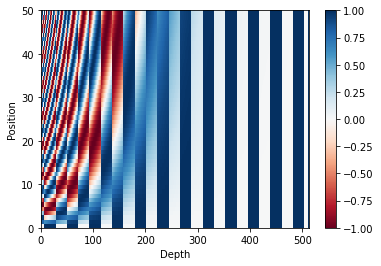

In [21]:
pos_encoding = positional_encoding(50, 512)
print (pos_encoding.shape)

plt.pcolormesh(pos_encoding[0], cmap='RdBu')
plt.xlabel('Depth')
plt.xlim((0, 512))
plt.ylabel('Position')
plt.colorbar()
plt.show()

# 4. Masking

Masking nhằm mục đích không đưa các vị trí padding trong câu vào như một input. Mask là ma trận có kích thước bằng với kích thước ma trận input và đánh dấu các vị trị padding (tương ứng với 0) bằng giá trị 1. Các giá trị còn lại bằng 0. 

In [0]:
def create_padding_mask(seq):
  seq = tf.cast(tf.math.equal(seq, 0), tf.float32)
  
  # add extra dimensions to add the padding
  # to the attention logits.
  return seq[:, tf.newaxis, tf.newaxis, :]  # (batch_size, 1, 1, seq_len)

In [23]:
x = tf.constant([[7, 6, 0, 0, 1], [1, 2, 3, 0, 0], [0, 0, 0, 4, 5]])
create_padding_mask(x)

<tf.Tensor: shape=(3, 1, 1, 5), dtype=float32, numpy=
array([[[[0., 0., 1., 1., 0.]]],


       [[[0., 0., 0., 1., 1.]]],


       [[[1., 1., 1., 0., 0.]]]], dtype=float32)>

Tiếp theo để ngăn cản ảnh hưởng của các từ tương lai vào dự đoán từ hiện tại. Chúng ta sẽ tiếp tục mask các vị trí tương lai bằng 1.

Như vậy tại vị trí cần dự báo từ thứ 3 thì chỉ từ thứ 1 và thứ 2 được đưa vào dự báo.

In [0]:
def create_look_ahead_mask(size):
  mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)
  return mask  # (seq_len, seq_len)

In [25]:
x = tf.random.uniform((1, 3))
temp = create_look_ahead_mask(x.shape[1])
temp

<tf.Tensor: shape=(3, 3), dtype=float32, numpy=
array([[0., 1., 1.],
       [0., 0., 1.],
       [0., 0., 0.]], dtype=float32)>

# 5. Scale dot Product attention

Một attention sẽ sử dụng input là 3 ma trận: $\mathbf{Q}$ (query), $\mathbf{K}$ (key) và $\mathbf{V}$ (value). Theo sơ đồ như sau:

<img src="https://www.tensorflow.org/images/tutorials/transformer/scaled_attention.png" width="500" alt="scaled_dot_product_attention">

Output thu được là ma trận attention của các từ lẫn nhau trong câu.

Diễn giải quá trình tính attention như sau:

* Sau khi thực hiện `MatMul` giữa $\mathbf{Q}$ và $\mathbf{K}$ --> thu được ma trận attention.

* Scale ma trận attention với nghịch đảo số độ sâu (chính là kích thước véc tơ dòng) của ma trận $\mathbf{K}$ là $\frac{1}{\mathbf{\sqrt{d_k}}}$ để tránh cho giá trị phần tử của ma trận attention quá lớn trong khi gradient thì quá nhỏ --> huấn luyện lâu.

* Thực hiện Masking. Ma trận mask là ma trận để ngăn cho những vị trí padding tham gia vào quá trình attention. Ma trận masking được nhân với -1E9 (là một giá trị gần với âm vô cùng). Sở dĩ ta thực hiện như vậy vì sau đó ma trận attention sẽ cộng với ma trận mask. Tại những vị trí padding sẽ có giá trị gần như âm vô cùng và khi tính phân phối softmax theo dòng sẽ thu được output là 0. Một lát nữa chúng ta sẽ thực nghiệm điều này.

* Sau khi tính phân phối softmax cho ma trận attention, chúng ta sẽ nhân ma trận attention với ma trận $\mathbf{V}$.

Toàn bộ quá trình phức tạp trên được tổng hợp trong công thức Attention:

$$\Large{Attention(Q, K, V) = softmax_k(\frac{QK^T}{\sqrt{d_k}}) V} $$


In [0]:
def scaled_dot_product_attention(q, k, v, mask):
  """Calculate the attention weights.
  q, k, v must have matching leading dimensions.
  k, v must have matching penultimate dimension, i.e.: seq_len_k = seq_len_v.
  The mask has different shapes depending on its type(padding or look ahead) 
  but it must be broadcastable for addition.
  
  Args:
    q: query shape == (..., seq_len_q, depth)
    k: key shape == (..., seq_len_k, depth)
    v: value shape == (..., seq_len_v, depth_v)
    mask: Float tensor with shape broadcastable 
          to (..., seq_len_q, seq_len_k). Defaults to None.
    
  Returns:
    output, attention_weights
  """

  matmul_qk = tf.matmul(q, k, transpose_b=True)  # (..., seq_len_q, seq_len_k)
  
  # scale matmul_qk
  dk = tf.cast(tf.shape(k)[-1], tf.float32) # depth
  scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)

  # add the mask to the scaled tensor.
  if mask is not None:
    scaled_attention_logits += (mask * -1e9)  

  # softmax is normalized on the last axis (seq_len_k) so that the scores
  # add up to 1.
  attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)  # (..., seq_len_q, seq_len_k)

  output = tf.matmul(attention_weights, v)  # (..., seq_len_q, depth_v)

  return output, attention_weights

Mask sẽ ngăn cản các vị trí được padding. Bên dưới ta sẽ thực nghiệm quá trình masking và xem hệ số attention sau khi đi qua phân phối softmax.

In [27]:
# with tf.Session() as sess:
mask = tf.constant([[0, 1, 1],
                    [0, 0, 1],
                    [0, 0, 0]], dtype = tf.float64)

scaled_attention_logit = tf.constant([[1, 3, 10],
                [1, 2, 5],
                [1, 1, 5]], dtype = tf.float64)

scaled_attention_logit += (mask * -1e9)
attention_weights = tf.nn.softmax(scaled_attention_logit, axis=-1)
print('scaled_attention_logit: ', scaled_attention_logit)
print('attention_weights: ', attention_weights)

scaled_attention_logit:  tf.Tensor(
[[ 1.00000000e+00 -9.99999997e+08 -9.99999990e+08]
 [ 1.00000000e+00  2.00000000e+00 -9.99999995e+08]
 [ 1.00000000e+00  1.00000000e+00  5.00000000e+00]], shape=(3, 3), dtype=float64)
attention_weights:  tf.Tensor(
[[1.         0.         0.        ]
 [0.26894142 0.73105858 0.        ]
 [0.01766842 0.01766842 0.96466316]], shape=(3, 3), dtype=float64)


Ta có thể thấy tại các vị trí padding được mask với giá trị bằng 1 thì attention_weights bằng 0.

Kết quả sau cùng sẽ thu được là tích giữa ma trận attention_weights với ma trận $\mathbf{V}$. Kết quả này sẽ đảm bảo:

* Phân bố attention giữa các véc tơ trong $\mathbf{V}$
* Loại bỏ những từ không liên quan ra khỏi attention.

Tiếp theo ta sẽ test hàm `scaled_dot_product_attention()`.

In [0]:
def print_out(q, k, v):
  temp_out, temp_attn = scaled_dot_product_attention(
      q, k, v, None)
  print ('Attention weights are:')
  print (temp_attn)
  print ('Output is:')
  print (temp_out)

In [29]:
np.set_printoptions(suppress=True)

temp_k = tf.constant([[10,0,0],
                      [0,10,0],
                      [0,0,10],
                      [0,0,10]], dtype=tf.float32)  # (4, 3)

temp_v = tf.constant([[   1,0],
                      [  10,0],
                      [ 100,5],
                      [1000,6]], dtype=tf.float32)  # (4, 2)

# This `query` aligns with the second `key`,
# so the second `value` is returned.
temp_q = tf.constant([[0, 10, 0]], dtype=tf.float32)  # (1, 3)
print_out(temp_q, temp_k, temp_v)

Attention weights are:
tf.Tensor([[0. 1. 0. 0.]], shape=(1, 4), dtype=float32)
Output is:
tf.Tensor([[10.  0.]], shape=(1, 2), dtype=float32)


Véc tơ attention là [0, 1, 0, 0] chỉ tập trung vào vị trí thứ 2. Do đó kết quả trả về là dòng thứ 2 của ma trận $\mathbf{V}$.

# 6. Multi-head Attention

<img src="https://www.tensorflow.org/images/tutorials/transformer/multi_head_attention.png" width="500" alt="multi-head attention">


Multi-head attention sẽ bao gồm 4 phần:

* Các linear layers và phân chi thành các nhiều heads.
* Scaled dot-product attention
* Concatenate các heads
* Linear layer cuối cùng.

Mỗi một multi-head attention block nhận 3 đầu vào: là các ma trận $\mathbf{Q}$, $\mathbf{K}$, $\mathbf{V}$. Sau đó `scale_dot_product_attention()` sẽ được sử dụng để tính toán trên từng head. Attention output của mỗi layer sau đó được concatenate và truyền qua một Dens layer.

Thay vì sử dụng một single head attention, chúng ta sử dụng nhiều multi-head attention là để mô hình có thể học được attention từ các vị trí trên những biểu diễn không gian khác nhau.

In [0]:
class MultiHeadAttention(tf.keras.layers.Layer):
  def __init__(self, d_model, num_heads):
    super(MultiHeadAttention, self).__init__()
    self.num_heads = num_heads
    self.d_model = d_model
    
    assert d_model % self.num_heads == 0
    
    self.depth = d_model // self.num_heads
    
    self.wq = tf.keras.layers.Dense(d_model)
    self.wk = tf.keras.layers.Dense(d_model)
    self.wv = tf.keras.layers.Dense(d_model)
    
    self.dense = tf.keras.layers.Dense(d_model)
        
  def split_heads(self, x, batch_size):
    """Split the last dimension into (num_heads, depth).
    Transpose the result such that the shape is (batch_size, num_heads, seq_len, depth)
    """
    x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
    return tf.transpose(x, perm=[0, 2, 1, 3])
    
  def call(self, v, k, q, mask):
    batch_size = tf.shape(q)[0]
    
    q = self.wq(q)  # (batch_size, seq_len, d_model)
    k = self.wk(k)  # (batch_size, seq_len, d_model)
    v = self.wv(v)  # (batch_size, seq_len, d_model)
    
    q = self.split_heads(q, batch_size)  # (batch_size, num_heads, seq_len_q, depth)
    k = self.split_heads(k, batch_size)  # (batch_size, num_heads, seq_len_k, depth)
    v = self.split_heads(v, batch_size)  # (batch_size, num_heads, seq_len_v, depth)
    
    # scaled_attention.shape == (batch_size, num_heads, seq_len_q, depth)
    # attention_weights.shape == (batch_size, num_heads, seq_len_q, seq_len_k)
    scaled_attention, attention_weights = scaled_dot_product_attention(
        q, k, v, mask)
    
    scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])  # (batch_size, seq_len_q, num_heads, depth)

    concat_attention = tf.reshape(scaled_attention, 
                                  (batch_size, -1, self.d_model))  # (batch_size, seq_len_q, d_model)

    output = self.dense(concat_attention)  # (batch_size, seq_len_q, d_model)
        
    return output, attention_weights

In [31]:
temp_mha = MultiHeadAttention(d_model=512, num_heads=8)
y = tf.random.uniform((1, 60, 512))  # (batch_size, encoder_sequence, d_model)
out, attn = temp_mha(y, k=y, q=y, mask=None)
out.shape, attn.shape

(TensorShape([1, 60, 512]), TensorShape([1, 8, 60, 60]))

Như vậy shape của attention sẽ là `(batch_size, num_head, seq_len_q, seq_len_k)` và shape của output  sẽ là `(batch_size, seq_len_q, d_model)`.

# 7. Point wise feed forward network

Point wise feed forward bao gồm 2 fully-connected layers với hàm ReLU activation.

In [0]:
def point_wise_feed_forward_network(d_model, dff):
  return tf.keras.Sequential([
      tf.keras.layers.Dense(dff, activation='relu'),  # (batch_size, seq_len, dff)
      tf.keras.layers.Dense(d_model)  # (batch_size, seq_len, d_model)
  ])

# 8. Encoder and Decoder


Toàn bộ kiến trúc của transformer sẽ bao gồm 2 nhánh Encoder và Decoder như bên dưới:

<img src="https://www.tensorflow.org/images/tutorials/transformer/transformer.png" width="600" alt="transformer">

* Câu input sẽ được embedding và truyền qua $N$ sub-layers block của encoder để sinh ra output cho mỗi từ trong câu.

* Decoder áp dụng encoder-decoder attention giữa output của encoder và input của decoder để dự báo next word.

## 8.1. Encoder layer

Mỗi một Encoder layer sẽ gồm 2 sublayers:

* Multi-head Attention (với padding mask)
* Point wise feed forward network.

In [0]:
class EncoderLayer(tf.keras.layers.Layer):
  def __init__(self, d_model, num_heads, dff, rate=0.1):
    super(EncoderLayer, self).__init__()

    self.mha = MultiHeadAttention(d_model, num_heads)
    self.ffn = point_wise_feed_forward_network(d_model, dff)

    self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    
    self.dropout1 = tf.keras.layers.Dropout(rate)
    self.dropout2 = tf.keras.layers.Dropout(rate)
    
  def call(self, x, training, mask):

    attn_output, _ = self.mha(x, x, x, mask)  # (batch_size, input_seq_len, d_model)
    attn_output = self.dropout1(attn_output, training=training)
    out1 = self.layernorm1(x + attn_output)  # (batch_size, input_seq_len, d_model)
    
    ffn_output = self.ffn(out1)  # (batch_size, input_seq_len, d_model)
    ffn_output = self.dropout2(ffn_output, training=training)
    out2 = self.layernorm2(out1 + ffn_output)  # (batch_size, input_seq_len, d_model)
    
    return out2

In [102]:
sample_encoder_layer = EncoderLayer(512, 8, 2048)

sample_encoder_layer_output = sample_encoder_layer(
    tf.random.uniform((64, 43, 512)), False, None)

sample_encoder_layer_output.shape  # (batch_size, input_seq_len, d_model)

TensorShape([64, 43, 512])

Nếu bạn chạy ra shape của output Encoder là `(batch_size, input_seq_length, d_model)` là đúng.

## 8.2. Decoder layer

Mỗi một layer của Decoder layer sẽ bao gồm 3 sublayers:

* Masked multi-head attention (với look ahead mask và padding mask).
* Multi-head attention (với padding mask). Ma trận $\mathbf{V}$, $\mathbf{K}$ cùng lấy output từ Encoder và ma trận $\mathbf{Q}$ nhận output từ _masked multi-head attention_.
* Point wise feed forward network

In [0]:
class DecoderLayer(tf.keras.layers.Layer):
  def __init__(self, d_model, num_heads, dff, rate=0.1):
    super(DecoderLayer, self).__init__()

    self.mha1 = MultiHeadAttention(d_model, num_heads)
    self.mha2 = MultiHeadAttention(d_model, num_heads)

    self.ffn = point_wise_feed_forward_network(d_model, dff)
 
    self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    self.layernorm3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    
    self.dropout1 = tf.keras.layers.Dropout(rate)
    self.dropout2 = tf.keras.layers.Dropout(rate)
    self.dropout3 = tf.keras.layers.Dropout(rate)
    
    
  def call(self, x, enc_output, training, 
           look_ahead_mask, padding_mask):
    # enc_output.shape == (batch_size, input_seq_len, d_model)

    attn1, attn_weights_block1 = self.mha1(x, x, x, look_ahead_mask)  # (batch_size, target_seq_len, d_model)
    attn1 = self.dropout1(attn1, training=training)
    out1 = self.layernorm1(attn1 + x)
    
    attn2, attn_weights_block2 = self.mha2(
        enc_output, enc_output, out1, padding_mask)  # (batch_size, target_seq_len, d_model)
    attn2 = self.dropout2(attn2, training=training)
    out2 = self.layernorm2(attn2 + out1)  # (batch_size, target_seq_len, d_model)
    
    ffn_output = self.ffn(out2)  # (batch_size, target_seq_len, d_model)
    ffn_output = self.dropout3(ffn_output, training=training)
    out3 = self.layernorm3(ffn_output + out2)  # (batch_size, target_seq_len, d_model)
    
    return out3, attn_weights_block1, attn_weights_block2

In [105]:
sample_decoder_layer = DecoderLayer(512, 8, 2048)

sample_decoder_layer_output, _, _ = sample_decoder_layer(
    tf.random.uniform((64, 50, 512)), sample_encoder_layer_output, 
    False, None, None)

sample_decoder_layer_output.shape  # (batch_size, target_seq_len, d_model)

TensorShape([64, 50, 512])

Output shape của Decoder sẽ là `(batch_size, target_seq_len, d_model)`.

## 8.3. Encoder

Toàn bộ Encoder sẽ bao gồm:

* Input Embedding
* Positional Encoding
* N encoder layers

Input sau khi được Embedding sẽ được cộng với Positional Encoding. Kết quả tổng thu được tiếp tục được truyền qua N encoder layers.

In [0]:
class Encoder(tf.keras.layers.Layer):
  def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size,
               maximum_position_encoding, rate=0.1):
    super(Encoder, self).__init__()

    self.d_model = d_model
    self.num_layers = num_layers
    
    self.embedding = tf.keras.layers.Embedding(input_vocab_size, d_model)
    self.pos_encoding = positional_encoding(maximum_position_encoding, 
                                            self.d_model)
    
    
    self.enc_layers = [EncoderLayer(d_model, num_heads, dff, rate) 
                       for _ in range(num_layers)]
  
    self.dropout = tf.keras.layers.Dropout(rate)
        
  def call(self, x, training, mask):

    seq_len = tf.shape(x)[1]
    
    # adding embedding and position encoding.
    x = self.embedding(x)  # (batch_size, input_seq_len, d_model)
    x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
    x += self.pos_encoding[:, :seq_len, :]

    x = self.dropout(x, training=training)
    
    for i in range(self.num_layers):
      x = self.enc_layers[i](x, training, mask)
    
    return x  # (batch_size, input_seq_len, d_model)

In [107]:
sample_encoder = Encoder(num_layers=2, d_model=512, num_heads=8, 
                         dff=2048, input_vocab_size=8500,
                         maximum_position_encoding=10000)

# Init sample tensorflow with shape 64 x 62 and data type int.
temp_input = tf.random.uniform((64, 62), dtype=tf.int64, minval=0, maxval=200)

sample_encoder_output = sample_encoder(temp_input, training=False, mask=None)

print (sample_encoder_output.shape)  # (batch_size, input_seq_len, d_model)

(64, 62, 512)


## 8.4. Decoder

Decoder sẽ bao gồm:

* Output Embedding
* Positional Embedding
* N encoder layers

Giá trị target được truyền qua Output Embedding và cộng với Positional Encoding. Tổng sau đó tiếp tục được truyền qua N encoder layers (Đã tính attention với output của Encoder). Output của decoder là input của linear layer cuối cùng.


In [0]:
class Decoder(tf.keras.layers.Layer):
  def __init__(self, num_layers, d_model, num_heads, dff, target_vocab_size,
               maximum_position_encoding, rate=0.1):
    super(Decoder, self).__init__()

    self.d_model = d_model
    self.num_layers = num_layers
    
    self.embedding = tf.keras.layers.Embedding(target_vocab_size, d_model)
    self.pos_encoding = positional_encoding(maximum_position_encoding, d_model)
    
    self.dec_layers = [DecoderLayer(d_model, num_heads, dff, rate) 
                       for _ in range(num_layers)]
    self.dropout = tf.keras.layers.Dropout(rate)
    
  def call(self, x, enc_output, training, 
           look_ahead_mask, padding_mask):

    seq_len = tf.shape(x)[1]
    attention_weights = {}
    
    x = self.embedding(x)  # (batch_size, target_seq_len, d_model)
    x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
    x += self.pos_encoding[:, :seq_len, :]
    
    x = self.dropout(x, training=training)

    for i in range(self.num_layers):
      x, block1, block2 = self.dec_layers[i](x, enc_output, training,
                                             look_ahead_mask, padding_mask)
      
      attention_weights['decoder_layer{}_block1'.format(i+1)] = block1
      attention_weights['decoder_layer{}_block2'.format(i+1)] = block2
    
    # x.shape == (batch_size, target_seq_len, d_model)
    return x, attention_weights

In [109]:
sample_decoder = Decoder(num_layers=2, d_model=512, num_heads=8, 
                         dff=2048, target_vocab_size=8000,
                         maximum_position_encoding=5000)
temp_input = tf.random.uniform((64, 26), dtype=tf.int64, minval=0, maxval=200)

output, attn = sample_decoder(temp_input, 
                              enc_output=sample_encoder_output, 
                              training=False,
                              look_ahead_mask=None, 
                              padding_mask=None)

output.shape, attn['decoder_layer2_block2'].shape

(TensorShape([64, 26, 512]), TensorShape([64, 8, 26, 62]))

# 9. Create transformer

MÔ hình transformer sẽ hình thành từ Encoder, Decoder và linear layer cuối cùng. Kết quả sau cùng là output của linear layer cuối cùng.

In [0]:
class Transformer(tf.keras.Model):
  def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size, 
               target_vocab_size, pe_input, pe_target, rate=0.1):
    super(Transformer, self).__init__()

    self.encoder = Encoder(num_layers, d_model, num_heads, dff, 
                           input_vocab_size, pe_input, rate)

    self.decoder = Decoder(num_layers, d_model, num_heads, dff, 
                           target_vocab_size, pe_target, rate)

    self.final_layer = tf.keras.layers.Dense(target_vocab_size)
    
  def call(self, inp, tar, training, enc_padding_mask, 
           look_ahead_mask, dec_padding_mask):
    # print('enc_padding_mask: ', enc_padding_mask)
    enc_output = self.encoder(inp, training, enc_padding_mask)  # (batch_size, inp_seq_len, d_model)
    
    # dec_output.shape == (batch_size, tar_seq_len, d_model)
    dec_output, attention_weights = self.decoder(
        tar, enc_output, training, look_ahead_mask, dec_padding_mask)
    
    final_output = self.final_layer(dec_output)  # (batch_size, tar_seq_len, target_vocab_size)
    
    return final_output, attention_weights

In [111]:
sample_transformer = Transformer(
    num_layers=2, d_model=512, num_heads=8, dff=2048, 
    input_vocab_size=8500, target_vocab_size=8000, 
    pe_input=10000, pe_target=6000)

temp_input = tf.random.uniform((64, 38), dtype=tf.int64, minval=0, maxval=200)
temp_target = tf.random.uniform((64, 36), dtype=tf.int64, minval=0, maxval=200)

fn_out, _ = sample_transformer(temp_input, temp_target, training=False, 
                               enc_padding_mask=None, 
                               look_ahead_mask=None,
                               dec_padding_mask=None)

fn_out.shape  # (batch_size, tar_seq_len, target_vocab_size)

TensorShape([64, 36, 8000])

# 10. Set hyperparameters

Chúng ta sẽ cần thiết lập các tham số cho mô hình bao gồm:

1. Các tham số kiến trúc mô hình:

* num_layers: Số lượng Attention sub-layer blocks của encoder và decoder.
* d_model: Kích thước của véc tơ embedding.
* num_heads: Số lượng các head trong một attention layer.
* dff: Số lượng token tối đa cho phép của văn bản đầu vào.

2. Các tham số huấn luyện:

* dropout_rate: Tỷ lệ drop out ở output.
* input_vocab_size: Số lượng từ vựng của input.
* target_vocab_size: Số lượng từ vựng của target.


In [0]:
num_layers = 4
d_model = 128
dff = 512
num_heads = 8

input_vocab_size = tokenizer_ipt.vocab_size + 2
target_vocab_size = tokenizer_opt.vocab_size + 2
dropout_rate = 0.1

In [113]:
print('input_vocab_size: ',  input_vocab_size)
print('target_vocab_size: ', target_vocab_size)

input_vocab_size:  8197
target_vocab_size:  8135


# 11. Optimizer

Sử dụng Adam optimizer với Learning rate đã được scheduler theo công thức tại [paper](https://arxiv.org/abs/1706.03762).

$$\Large{lrate = d_{model}^{-0.5} * min(step{\_}num^{-0.5}, step{\_}num * warmup{\_}steps^{-1.5})}$$

In [0]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
  def __init__(self, d_model, warmup_steps=4000):
    super(CustomSchedule, self).__init__()
    
    self.d_model = d_model
    self.d_model = tf.cast(self.d_model, tf.float32)

    self.warmup_steps = warmup_steps
    
  def __call__(self, step):
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps ** -1.5)
    
    return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

In [0]:
learning_rate = CustomSchedule(d_model)

optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98, 
                                     epsilon=1e-9)

Text(0.5, 0, 'Train Step')

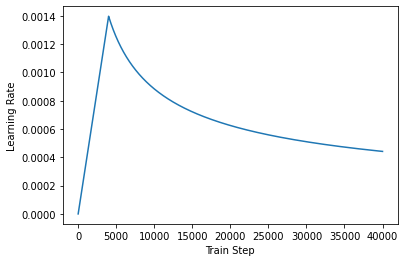

In [116]:
temp_learning_rate_schedule = CustomSchedule(d_model)

plt.plot(temp_learning_rate_schedule(tf.range(40000, dtype=tf.float32)))
plt.ylabel("Learning Rate")
plt.xlabel("Train Step")

# 12. Loss and Metrics

Bởi vì câu mục tiêu và được padded, do đó chúng ta cũng phải áp dụng padding mask khi tính toán loss function.

In [0]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

In [0]:
def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask
  
  return tf.reduce_sum(loss_)/tf.reduce_sum(mask)

In [0]:
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(
    name='train_accuracy')

# 13. Training and checkpointing

In [0]:
transformer = Transformer(num_layers=num_layers, d_model=d_model, num_heads=num_heads, dff=dff,
                          input_vocab_size=input_vocab_size, target_vocab_size=target_vocab_size, 
                          pe_input=input_vocab_size, 
                          pe_target=target_vocab_size,
                          rate=dropout_rate)

In [0]:
def create_masks(inp, tar):
  # Encoder padding mask
  enc_padding_mask = create_padding_mask(inp)

  # Used in the 2nd attention block in the decoder.
  # This padding mask is used to mask the encoder outputs.
  dec_padding_mask = create_padding_mask(inp)
  
  # Used in the 1st attention block in the decoder.
  # It is used to pad and mask future tokens in the input received by 
  # the decoder.
  look_ahead_mask = create_look_ahead_mask(tf.shape(tar)[1])
  dec_target_padding_mask = create_padding_mask(tar)
  combined_mask = tf.maximum(dec_target_padding_mask, look_ahead_mask)
  return enc_padding_mask, combined_mask, dec_padding_mask

In [0]:
x = tf.constant([[7, 6, 0, 0, 0], [1, 2, 3, 0, 0], [6, 0, 0, 0, 0]])
y = tf.constant([[1, 4, 5, 0, 0], [1, 4, 3, 0, 0], [1, 2, 0, 0, 0]])
enc_padding_mask, combined_mask, dec_padding_mask = create_masks(x, y)

In [123]:
combined_mask

<tf.Tensor: shape=(3, 1, 5, 5), dtype=float32, numpy=
array([[[[0., 1., 1., 1., 1.],
         [0., 0., 1., 1., 1.],
         [0., 0., 0., 1., 1.],
         [0., 0., 0., 1., 1.],
         [0., 0., 0., 1., 1.]]],


       [[[0., 1., 1., 1., 1.],
         [0., 0., 1., 1., 1.],
         [0., 0., 0., 1., 1.],
         [0., 0., 0., 1., 1.],
         [0., 0., 0., 1., 1.]]],


       [[[0., 1., 1., 1., 1.],
         [0., 0., 1., 1., 1.],
         [0., 0., 1., 1., 1.],
         [0., 0., 1., 1., 1.],
         [0., 0., 1., 1., 1.]]]], dtype=float32)>

Chúng ta sẽ tạo ra một checkpoint path và checkpoint manager để lưu checkpoints (là trạng thái của model, có thể load lại để huấn luyện lại) sau mỗi `n=5` epochs.

In [0]:
checkpoint_path = "./checkpoints/train_500k"

ckpt = tf.train.Checkpoint(transformer=transformer,
                           optimizer=optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

# if a checkpoint exists, restore the latest checkpoint.
if ckpt_manager.latest_checkpoint:
  ckpt.restore(ckpt_manager.latest_checkpoint)
  print ('Latest checkpoint restored!!')

**Note:** Layer embedding của Encoder sẽ lưu `input_vocabulary_size` và `target_vocabulary_size` theo bộ dữ liệu. Do đó nếu huấn luyện trên bộ dữ liệu mới thì sẽ không thể load lại model từ checkpoints cũ. Chúng ta cần chuyển sang một bộ checkpoints mới.

Target sẽ được phân thành `tar_inp` và `tar_real`. `tar_inp` được truyền vào như là một input cho decoder. `tar_real` tương tự như `tar_inp` nhưng được dịch chuyển 1 đơn vị: Tại mỗi vị trí trong `tar_inp` ta sẽ có 1 vị trí tương ứng trong `tar_real` là token tiếp theo nên được dự báo.

Chẳng hạn trong câu sentence = `SOS một con sư tử đang ngủ say trong rừng SOS`

`tar_inp` = `SOS một con sư tử đang ngủ say trong rừng`

`tar_real` = `một con sư tử đang ngủ say trong rừng SOS`

transformer là một mô hình tự hồi qui (auto-regressive model, một dạng model trong chuỗi thời gian sử dụng chính giá trị quá khử của chuỗi để dự báo giá trị hiện tại của chuỗi): và tạo ra một dự báo tại mỗi một time step. Nó sử dụng output của nó từ trước đến hiện tại để quyết định xem từ tiếp theo là gì.

Trong quá trình huấn luyện ví dụ này sử dụng kỹ thuật teacher-forcing. Teacher-forcing sẽ bỏ qua giá trị đúng ở output để tới time step tiếp theo mà không quan tâm tới mô hình dự báo ra là gì tại time step hiện tại.

Khi transformer dự báo mỗi từ, `self-attention` cho phép nó nhìn vào các từ liền trước trong chuỗi input để dự báo tốt hơn từ tiếp theo.





In [0]:
EPOCHS = 100

In [0]:
# The @tf.function trace-compiles train_step into a TF graph for faster
# execution. The function specializes to the precise shape of the argument
# tensors. To avoid re-tracing due to the variable sequence lengths or variable
# batch sizes (the last batch is smaller), use input_signature to specify
# more generic shapes.

train_step_signature = [
    tf.TensorSpec(shape=(None, None), dtype=tf.int64),
    tf.TensorSpec(shape=(None, None), dtype=tf.int64),
]

@tf.function(input_signature=train_step_signature)
def train_step(inp, tar):
  tar_inp = tar[:, :-1]
  tar_real = tar[:, 1:]
  enc_padding_mask, combined_mask, dec_padding_mask = create_masks(inp, tar_inp)
  with tf.GradientTape() as tape:
    predictions, _ = transformer(inp, tar_inp, 
                                 True, 
                                 enc_padding_mask, 
                                 combined_mask, 
                                 dec_padding_mask)
    
    loss = loss_function(tar_real, predictions)

  gradients = tape.gradient(loss, transformer.trainable_variables)    
  optimizer.apply_gradients(zip(gradients, transformer.trainable_variables))
  
  train_loss(loss)
  train_accuracy(tar_real, predictions)

In [127]:
for epoch in range(EPOCHS):
  start = time.time()
  
  train_loss.reset_states()
  train_accuracy.reset_states()
  
  # inp -> non_diacritic, tar -> diacritic
  for (batch, (inp, tar)) in enumerate(train_dataset):
    train_step(inp, tar)
    
    if batch % 50 == 0:
      print ('Epoch {} Batch {} Loss {:.4f} Accuracy {:.4f}'.format(
          epoch + 1, batch, train_loss.result(), train_accuracy.result()))
      
  if (epoch + 1) % 5 == 0:
    ckpt_save_path = ckpt_manager.save()
    print ('Saving checkpoint for epoch {} at {}'.format(epoch+1,
                                                         ckpt_save_path))
    
  print ('Epoch {} Loss {:.4f} Accuracy {:.4f}'.format(epoch + 1, 
                                                train_loss.result(), 
                                                train_accuracy.result()))

  print ('Time taken for 1 epoch: {} secs\n'.format(time.time() - start))

Epoch 1 Batch 0 Loss 0.2649 Accuracy 0.4796
Epoch 1 Batch 50 Loss 0.2963 Accuracy 0.4298
Epoch 1 Batch 100 Loss 0.2766 Accuracy 0.4315
Epoch 1 Batch 150 Loss 0.2642 Accuracy 0.4315
Epoch 1 Batch 200 Loss 0.2577 Accuracy 0.4350
Epoch 1 Batch 250 Loss 0.2498 Accuracy 0.4351
Epoch 1 Batch 300 Loss 0.2453 Accuracy 0.4347
Epoch 1 Batch 350 Loss 0.2435 Accuracy 0.4345


KeyboardInterrupt: ignored

# 14. Evaluate

Các bước sau đây được sử dụng để đánh giá:

* Mã hóa câu đầu vào bằng cách sử dụng tokenizer input (tokenizer_pt). Ngoài ra , thêm mã bắt đầu và kết thúc để đầu vào tương đương với những gì mô hình đã huấn luyện. Đây sẽ là đầu vào cho encoder.

* Đầu vào cho decoder là start token có index bằng với tokenizer_en.vocab_size.

* Tính toán các padding masks và look ahead masks.

* decoder sau đó đưa ra các dự đoán dựa trên đầu ra của encoder và đầu ra của chính nó (self-attention).

* Chọn từ cuối cùng và tính argmax của từ đó.

* Nối từ dự đoán với đầu vào decoder input khi chuyển từ đó đến decoder.

* Trong phương pháp này, decoder dự đoán từ tiếp theo dựa trên các từ trước đó mà nó dự đoán.

In [0]:
MAX_LENGTH = 40

def evaluate(inp_sentence):
  start_token = [tokenizer_ipt.vocab_size]
  end_token = [tokenizer_ipt.vocab_size + 1]
  
  # inp sentence is non_diacritic, hence adding the start and end token
  inp_sentence = start_token + tokenizer_ipt.encode(inp_sentence) + end_token
  encoder_input = tf.expand_dims(inp_sentence, 0)
  
  # as the target is exist diacritic, the first word to the transformer should be the
  # english start token.
  decoder_input = [tokenizer_opt.vocab_size]
  output = tf.expand_dims(decoder_input, 0)
    
  for i in range(MAX_LENGTH):
    enc_padding_mask, combined_mask, dec_padding_mask = create_masks(
        encoder_input, output)
  
    # predictions.shape == (batch_size, seq_len, vocab_size)
    predictions, attention_weights = transformer(encoder_input, 
                                                 output,
                                                 False,
                                                 enc_padding_mask,
                                                 combined_mask,
                                                 dec_padding_mask)
    
    # select the last word from the seq_len dimension
    predictions = predictions[: ,-1:, :]  # (batch_size, 1, vocab_size)

    predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)
    
    # return the result if the predicted_id is equal to the end token
    if predicted_id == tokenizer_opt.vocab_size+1:
      return tf.squeeze(output, axis=0), attention_weights
    
    # concatentate the predicted_id to the output which is given to the decoder
    # as its input.
    output = tf.concat([output, predicted_id], axis=-1)

  return tf.squeeze(output, axis=0), attention_weights

Tiếp theo ta sẽ xây dựng biểu đồ heatmap visualize attention weight giữa 2 từ bất kỳ được lấy từ câu input và câu target.

In [0]:
def plot_attention_weights(attention, sentence, result, layer):
  fig = plt.figure(figsize=(16, 8))
  
  sentence = tokenizer_ipt.encode(sentence)
  
  attention = tf.squeeze(attention[layer], axis=0)
  
  for head in range(attention.shape[0]):
    ax = fig.add_subplot(2, 4, head+1)
    
    # plot the attention weights
    ax.matshow(attention[head][:-1, :], cmap='viridis')

    fontdict = {'fontsize': 10}
    
    ax.set_xticks(range(len(sentence)+2))
    ax.set_yticks(range(len(result)))
    
    ax.set_ylim(len(result)-1.5, -0.5)
        
    ax.set_xticklabels(
        ['<start>']+[tokenizer_ipt.decode([i]) for i in sentence]+['<end>'], 
        fontdict=fontdict, rotation=90)
    
    ax.set_yticklabels([tokenizer_opt.decode([i]) for i in result 
                        if i < tokenizer_opt.vocab_size], 
                       fontdict=fontdict)
    
    ax.set_xlabel('Head {}'.format(head+1))
  
  plt.tight_layout()
  plt.show()

Hàm translate sẽ có tác dụng chuyển đánh giá câu input và trả ra câu dự báo bằng cách giải mã chuỗi indices token được dự báo từ mô hình.

In [0]:
def translate(sentence, plot=''):
  result, attention_weights = evaluate(sentence)
  
  predicted_sentence = tokenizer_opt.decode([i for i in result 
                                            if i < tokenizer_opt.vocab_size])  

  print('Input: {}'.format(sentence))
  print('Predicted translation: {}'.format(predicted_sentence))
  
  if plot:
    plot_attention_weights(attention_weights, sentence, result, plot)

In [220]:
translate("tieng Viet la ngon ngu trong sang nhat the gioi")

Input: tieng Viet la ngon ngu trong sang nhat the gioi
Predicted translation: tiếng Việt là ngôn ngữ trong sáng nhất thế giới



Input: hom nay thoi tiet tai Ha Noi rat nong
Predicted translation: hôm nay thời tiết tại Hà Nội rất nóng



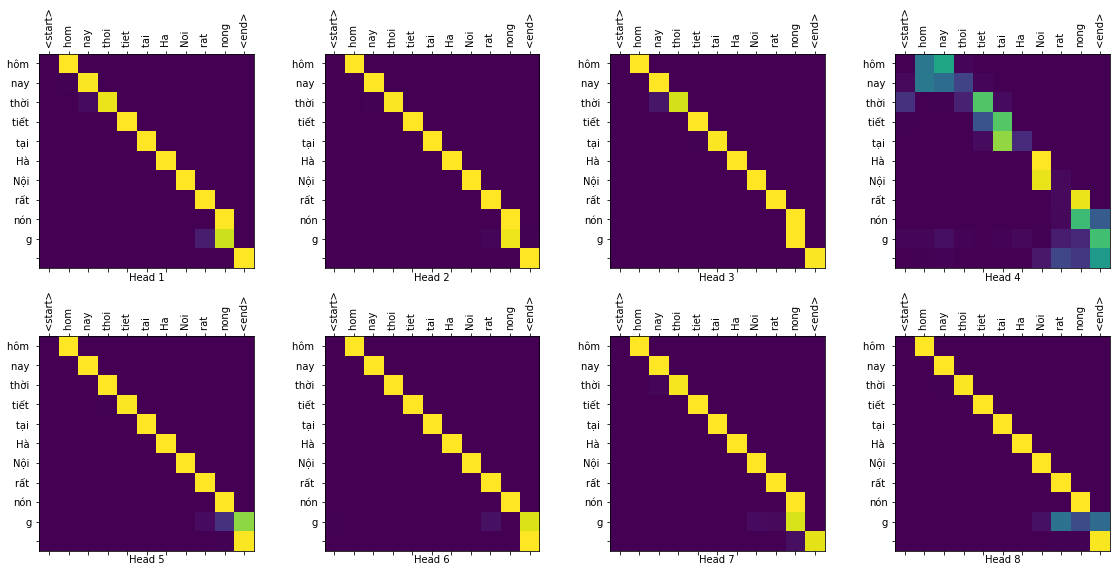

Real translation: this is the first book i've ever done.


In [133]:
translate("hom nay thoi tiet tai Ha Noi rat nong", plot='decoder_layer4_block2')
print ("Real translation: hôm nay thời tiết tại Hà Nội rất nóng")

Ta có thể thấy khi visualize `encoder-decoder attention` từ một block layer trong decoder cho từng head trong multi-heads thì các vị trí từ ở encoder cùng mà vị trí với từ ở decoder sẽ có attention weight cao hơn.

# 15. Pretrain model

Nếu bạn không muốn huấn luyện model từ đầu, bạn có thể sử dụng pretrained model đã được tôi huấn luyện bằng cách download các thư mục:

* tokenizer: là tokenizer cho các subwords dùng để chuyển sequence sang indice.

* checkpoint: Là checkpint, nơi lưu trữ last pretrain model để bạn có thể load lại cho dự báo.

Cả 2 đều được đặt trong folder [themdau_tv](https://drive.google.com/drive/folders/11KSVIIDWlNknVZmoL1ugW8fxHJyrNBCr?usp=sharing).


In [209]:
!ls tokenizer

input_vocab.txt   tokenizer_ipt.pkl	  tokenizer_opt.pkl
output_vocab.txt  tokenizer_ipt.subwords  tokenizer_opt.subwords


In [0]:
import tensorflow_datasets as tfds
import tensorflow as tf

import time
import numpy as np
import matplotlib.pyplot as plt

# Load tokenizer
import pickle

def _save_pickle(path, obj):
  with open(path, 'wb') as f:
    pickle.dump(obj, f)

def _load_pickle(path):
  with open(path, 'rb') as f:
    obj = pickle.load(f)
  return obj

tokenizer_ipt = _load_pickle('tokenizer/tokenizer_ipt.pkl')
tokenizer_opt = _load_pickle('tokenizer/tokenizer_opt.pkl')

# Khai báo tham số
num_layers = 4
d_model = 128
dff = 512
num_heads = 8

input_vocab_size = tokenizer_ipt.vocab_size + 2
target_vocab_size = tokenizer_opt.vocab_size + 2
dropout_rate = 0.1
learning_rate = 0.01

Nếu các bạn bắt đầu từ mục 15 này ngay từ đầu. Trước khi load model thì các bạn cần chạy lại toàn bộ code cho layers và mô hình ở mục 8 và 9. Đây là hạn chế của notebook so với python file. Trên python file chúng ta có thể import class giữa các files với nhau khá dễ dàng.

In [0]:
# Load model
transformer = Transformer(num_layers=num_layers, d_model=d_model, num_heads=num_heads, dff=dff,
                          input_vocab_size=input_vocab_size, target_vocab_size=target_vocab_size, 
                          pe_input=input_vocab_size, 
                          pe_target=target_vocab_size,
                          rate=dropout_rate)

checkpoint_path = "./checkpoints/train_500k"

ckpt = tf.train.Checkpoint(transformer=transformer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

# if a checkpoint exists, restore the latest checkpoint.
if ckpt_manager.latest_checkpoint:
  ckpt.restore(ckpt_manager.latest_checkpoint)

In [0]:
def evaluate(inp_sentence):
  start_token = [ipt_vocab_size]
  end_token = [ipt_vocab_size+1]
  
  # inp sentence is non_diacritic, hence adding the start and end token
  inp_sentence = start_token + tokenizer_ipt.encode(inp_sentence) + end_token
  encoder_input = tf.expand_dims(inp_sentence, 0)
  
  # as the target is exist diacritic, the first word to the transformer should be the
  # english start token.
  decoder_input = [opt_vocab_size]
  output = tf.expand_dims(decoder_input, 0)
    
  for i in range(MAX_LENGTH):
    enc_padding_mask, combined_mask, dec_padding_mask = create_masks(
        encoder_input, output)
  
    # predictions.shape == (batch_size, seq_len, vocab_size)
    predictions, attention_weights = transformer(encoder_input, 
                                                 output,
                                                 False,
                                                 enc_padding_mask,
                                                 combined_mask,
                                                 dec_padding_mask)
    
    # select the last word from the seq_len dimension
    predictions = predictions[: ,-1:, :]  # (batch_size, 1, vocab_size)

    predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)
    
    # return the result if the predicted_id is equal to the end token
    if predicted_id == opt_vocab_size+1:
      return tf.squeeze(output, axis=0), attention_weights
    
    # concatentate the predicted_id to the output which is given to the decoder
    # as its input.
    output = tf.concat([output, predicted_id], axis=-1)

  return tf.squeeze(output, axis=0), attention_weights

In [0]:
def add_diacritic(sentence, plot=''):
  result, attention_weights = evaluate(sentence)
  predicted_sentence = tokenizer_opt.decode([i for i in result 
                                            if i < opt_vocab_size])  
  print('Input: {}'.format(sentence))
  print('Predicted translation: {}'.format(predicted_sentence))
  if plot:
    plot_attention_weights(attention_weights, sentence, result, plot)

Bên dưới là kết quả của một vài câu thử nghiệm

In [218]:
add_diacritic("hom nay thoi tiet tai Ha Noi rat nong")

Input: hom nay thoi tiet tai Ha Noi rat nong
Predicted translation: hôm nay thời tiết tại Hà Nội rất nóng



In [214]:
add_diacritic("toi la mot nguoi rat yeu thich AI")

Input: toi la mot nguoi rat yeu thich AI
Predicted translation: tôi là một người rất yêu thích AI



In [217]:
add_diacritic("toi muon tro thanh mot AI researcher noi tieng tren the gioi")

Input: toi muon tro thanh mot AI researcher noi tieng tren the gioi
Predicted translation: tôi muốn trở thành một AI researcher nổi tiếng trên thế giới



# 16. Tổng kết

Như vậy qua bài viết này chúng ta đã được hướng dẫn từ bước thu thập dữ liệu, xây dựng các layers của kiến trúc transformer, huấn luyện mô hình và dự báo từ pretrained model.

Thông qua việc thực hành chúng ta sẽ hiểu rõ hơn cấu trúc từng layer và các xử lý attention, mask trong tác vụ seq2seq. Bản thân tôi cũng phải bỏ ra rất nhiều thời gian để nghiên cứu bài viết này và viết lại như một tài liệu tham khảo khi cần. Bài viết được lấy từ nhiều nguồn liệt kê bên dưới.

# 17. Tài liệu tham khảo

1. [Transformer model for language understanding](https://www.tensorflow.org/tutorials/text/transformer)

2. [Bài 4 - Attention is all you need - Khanh Blog](https://phamdinhkhanh.github.io/2019/06/18/AttentionLayer.html)

3. [Bài 7 - Pytorch Seq2seq model correct spelling - Khanh Blog](https://phamdinhkhanh.github.io/2019/08/19/CorrectSpellingVietnamseTonePrediction.html)

4. [Bài 36 - BERT model - Khanh Blog](https://phamdinhkhanh.github.io/2020/05/23/BERTModel.html)